<a href="https://colab.research.google.com/github/ianbrawlstars/connecting-four-reinforcement-learning/blob/main/Connecting_four_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use tensorflow 1.x

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Import and check version of tensorflow


In [2]:
import tensorflow as tf
tf.__version__
import numpy as np

# Install a customized package for OpenAI Gym

In [3]:
!pip install 'kaggle-environments>=0.1.6'
!pip install 'recordtype'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 11.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.2 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Custom Environment inherited from OpenAI's Gym

In [4]:
from kaggle_environments import make, evaluate
from gym import spaces

class ConnectFourGym:
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces 
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(self.rows,self.columns,1), dtype=int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1), reward, done, _

# In this example, we train the agent to beat the random agent

In [5]:
# Create ConnectFour environment
env = ConnectFourGym(agent2="random")

In [6]:
!apt-get update
!apt-get install -y cmake libopenmpi-dev python3-dev zliblg-dev
!pip install "stable-baselines[mpi]==2.10.2"

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://ppa.lau

In [7]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from stable_baselines.bench import Monitor
from stable_baselines.common.vec_env import DummyVecEnv

# Create directory for logging training information
log_dir = "ppo/"
os.makedirs(log_dir, exist_ok=True)

# Logging process
monitor_env = Monitor(env, log_dir, allow_early_resets=True)

# Create a vectorized environment
vec_env = DummyVecEnv([lambda: monitor_env])



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


# Stable Basline

In [8]:
from stable_baselines import PPO1
from stable_baselines.common.tf_layers import conv, linear, conv_to_fc
from stable_baselines.common.policies import CnnPolicy

# Neural network for predicting action values
def modified_cnn(scaled_images, **kwargs):
  activ = tf.nn.relu
  layer_1 = activ(conv(scaled_images, "c1", n_filters=32, filter_size=3, stride=1, init_scale=np.sqrt(2), **kwargs))
  layer_2 = activ(conv(layer_1, "c2", n_filters=64, filter_size=3, stride=1, init_scale=np.sqrt(2), **kwargs))
  layer_2 = conv_to_fc(layer_2)
  
  return activ(linear(layer_2, "fc1", n_hidden=512, init_scale=np.sqrt(2)))

class CustomCnnPolicy(CnnPolicy):
  def __init__(self, *args, **kwargs):
    super(CustomCnnPolicy, self).__init__(*args, **kwargs, cnn_extractor=modified_cnn)

model = PPO1(CustomCnnPolicy, vec_env, verbose=0)















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Train the Model

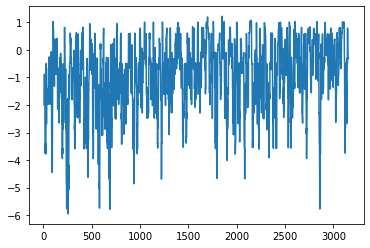

In [16]:
# Train agent
model.learn(total_timesteps=2000)

# Plot cumulative reward
with open(os.path.join(log_dir, "monitor.csv"), "rt") as fh:
  firstline = fh.readline()
  assert firstline[0] == "#"
  df = pd.read_csv(fh, index_col=None)['r']

df.rolling(window=10).mean().plot()
plt.show()

In [17]:
def agent1(obs, config):
  # Use the best model to select a column
  col, _ = model.predict(np.array(obs['board']).reshape(6,7,1))
  # Check if selected column is valid
  is_valid = (obs['board'][int(col)] == 0)
  # If not valid, select random move.
  if is_valid:
    return int(col)
  else:
    return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [22]:
# Create the game environment
env = make("connectx")

# Two random agents play one game round
env.run([agent1, "random"])

# Show the game
env.render(mode="ipython")

In [23]:
def get_win_percentage(agent1, agent2, n_rounds=100):
  # Use default Connect Four setup
  config = {"rows": 6, "columns": 7, "inarow": 4}
  # Agent 1 goes first (roughly) half the time
  outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
  # Agent 2 goes first (roughly) half the time
  outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
  print("Agent 1 win percentage: ", np.round(outcomes.count([1,-1])/len(outcomes), 2))
  print("Agent 2 win percentage: ", np.round(outcomes.count([-1,1])/len(outcomes), 2))
  print("Number of Invalid Plays by Agent 1: ", outcomes.count([None, 0]))
  print("Number of Invalid Plays by Agent 2: ", outcomes.count([0, None]))

In [24]:
get_win_percentage(agent1=agent1, agent2="random")

Agent 1 win percentage:  0.67
Agent 2 win percentage:  0.33
Number of Invalid Plays by Agent 1:  0
Number of Invalid Plays by Agent 2:  0
